In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd


import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head(5)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 데이터전처리(추상적 요약)

In [4]:
## 정규화 사전(축약같은걸 원문으로 변경)

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [5]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    
    # 
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
data['headlines']

0        upGrad learner switches to career in ML & Al w...
1        Delhi techie wins free food from Swiggy for on...
2        New Zealand end Rohit Sharma-led India's 12-ma...
3        Aegon life iTerm insurance plan helps customer...
4        Have known Hirani for yrs, what if MeToo claim...
                               ...                        
98396    CRPF jawan axed to death by Maoists in Chhatti...
98397    First song from Sonakshi Sinha's 'Noor' titled...
98398           'The Matrix' film to get a reboot: Reports
98399    Snoop Dogg aims gun at clown dressed as Trump ...
98400    Madhesi Morcha withdraws support to Nepalese g...
Name: headlines, Length: 98360, dtype: object

In [10]:
data['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98360, dtype: object

In [11]:
clean_text = []

data['text'] = data['text'].apply(lambda x: preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  []


In [12]:
clean_headlines = []

data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  []


In [13]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 데이터 분포 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


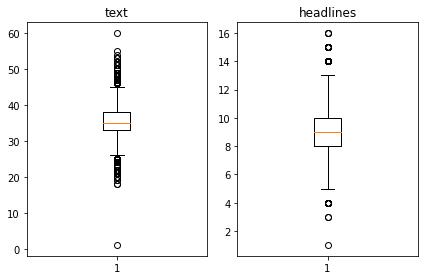

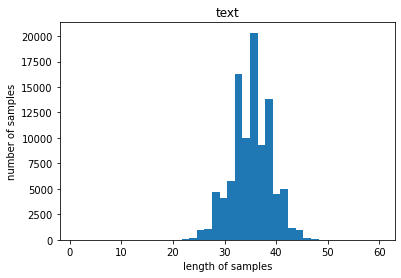

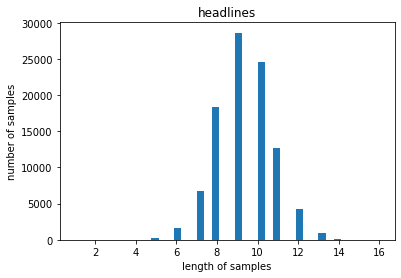

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 50
headlines_max_len = 14

In [17]:
filtered_data = data[(data['text'].apply(lambda x: len(x.split()) <= text_max_len)) &
(data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len))]

In [18]:
data = filtered_data.copy()

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블|

In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [21]:
n_of_val = int(len(encoder_input)*0.15)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14748


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 83576
훈련 레이블의 개수 : 83576
테스트 데이터의 개수 : 14748
테스트 레이블의 개수 : 14748


## Tokenizer

In [23]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 71356
등장 빈도가 7번 이하인 희귀 단어의 수: 50029
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21327
단어 집합에서 희귀 단어의 비율: 70.11183362296093
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7058737865898808


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 모든 요소를 문자열로 변환하여 일관된 형식으로 만듭니다.
encoder_input_train = [str(text) if not isinstance(text, str) else text for text in encoder_input_train]

# 단어 집합 크기 설정 및 토크나이저 초기화
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)

# 토크나이저를 훈련 데이터에 맞추어 학습시킵니다.
src_tokenizer.fit_on_texts(encoder_input_train)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 모든 요소가 문자열인지 확인하고, 아니라면 문자열로 변환
encoder_input_train = [str(text) if not isinstance(text, str) else text for text in encoder_input_train]
encoder_input_test = [str(text) if not isinstance(text, str) else text for text in encoder_input_test]

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 출력
print(encoder_input_train[:3])

[[821, 106, 194, 97, 4690, 205, 1520, 1258, 237, 526, 2442, 4240, 2143, 3, 13, 37, 8851, 37, 9800, 526, 11973, 9998, 23, 711, 17953, 17954, 99, 2442, 4240, 301, 711, 6114, 658, 3478], [2819, 2040, 256, 6503, 16467, 1184, 614, 1074, 1515, 727, 573, 793, 1002, 332, 34, 3, 54, 528, 7265, 6748, 2653, 4643, 11365, 850, 11974, 9999, 1622, 1516, 567, 867, 146, 1452], [309, 936, 5721, 5232, 1, 40, 3341, 922, 813, 467, 377, 2415, 1894, 312, 141, 242, 173, 134, 1162, 263, 9003, 5, 196, 1099, 5624, 4, 5232, 405, 29, 312, 425]]


In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30780
등장 빈도가 5번 이하인 희귀 단어의 수: 20065
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10715
단어 집합에서 희귀 단어의 비율: 65.18843404808317
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.469222466594401


In [29]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 262, 908, 1026, 1423, 627, 4890, 15, 20, 4077], [1, 2617, 15, 7525, 6, 2878, 6, 9811, 4, 5047], [1, 1228, 1940, 8004, 24, 10, 129, 13, 3863, 2715, 1726], [1, 9812, 2772, 866, 1897, 12, 112, 1898], [1, 9082, 11, 109, 909, 16, 13, 216, 838, 29]]
target
decoder  [[262, 908, 1026, 1423, 627, 4890, 15, 20, 4077, 2], [2617, 15, 7525, 6, 2878, 6, 9811, 4, 5047, 2], [1228, 1940, 8004, 24, 10, 129, 13, 3863, 2715, 1726, 2], [9812, 2772, 866, 1897, 12, 112, 1898, 2], [9082, 11, 109, 909, 16, 13, 216, 838, 29, 2]]


In [30]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 83575
훈련 레이블의 개수 : 83575
테스트 데이터의 개수 : 14748
테스트 레이블의 개수 : 14748


In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 어텐션 메커니즘 구현
    - 모델 셀계(Bi-LSTM)

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Hyperparameters
embedding_dim = 256
hidden_size = 256

# Encoder
encoder_inputs = Input(shape=(text_max_len,))

# Encoder embedding layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# Encoder Bi-LSTM 1
encoder_bilstm1 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bilstm1(enc_emb)

# Combine forward and backward states
state_h1 = Concatenate()([forward_h1, backward_h1])
state_c1 = Concatenate()([forward_c1, backward_c1])

# Encoder Bi-LSTM 2
encoder_bilstm2 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bilstm2(encoder_output1)

# Combine forward and backward states
state_h2 = Concatenate()([forward_h2, backward_h2])
state_c2 = Concatenate()([forward_c2, backward_c2])

# Encoder Bi-LSTM 3
encoder_bilstm3 = Bidirectional(LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4))
encoder_output3, forward_h3, forward_c3, backward_h3, backward_c3 = encoder_bilstm3(encoder_output2)

# Combine forward and backward states
state_h3 = Concatenate()([forward_h3, backward_h3])
state_c3 = Concatenate()([forward_c3, backward_c3])

# Decoder
decoder_inputs = Input(shape=(None,))

# Decoder embedding layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM with the final encoder states as initial states
decoder_lstm = LSTM(hidden_size * 2, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# Decoder output layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 512), (N 1050624     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 512), (N 1574912     bidirectional[0][0]              
______________________________________________________________________________________________

In [33]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 50, 512), (N 1050624     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 50, 512), (N 1574912     bidirectional[0][0]              
____________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
327/327 [==============================] - 90s 243ms/step - loss: 4.7811 - val_loss: 4.3360
Epoch 2/50
327/327 [==============================] - 79s 243ms/step - loss: 4.1242 - val_loss: 3.8724
Epoch 3/50
327/327 [==============================] - 79s 243ms/step - loss: 3.7035 - val_loss: 3.5812
Epoch 4/50
327/327 [==============================] - 80s 243ms/step - loss: 3.4012 - val_loss: 3.4012
Epoch 5/50
327/327 [==============================] - 80s 243ms/step - loss: 3.1641 - val_loss: 3.2774
Epoch 6/50
327/327 [==============================] - 80s 243ms/step - loss: 2.9701 - val_loss: 3.2090
Epoch 7/50
327/327 [==============================] - 80s 243ms/step - loss: 2.8032 - val_loss: 3.1435
Epoch 8/50
327/327 [==============================] - 80s 243ms/step - loss: 2.6547 - val_loss: 3.0990
Epoch 9/50
327/327 [==============================] - 80s 243ms/step - loss: 2.5238 - val_loss: 3.0820
Epoch 10/50
327/327 [==============================] - 80s 244ms/step - l

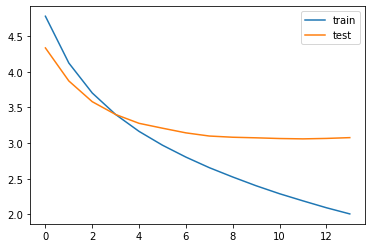

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 실제 결과와 요약문 비교(추상적 요약)

In [36]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [37]:
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

decoder_state_input_h = Input(shape=(hidden_size * 2,))
decoder_state_input_c = Input(shape=(hidden_size * 2,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

In [38]:
from tensorflow.keras.layers import Input, Concatenate

# Correcting the shape of `decoder_hidden_state_input` to match the doubled hidden size from the Bi-LSTM encoder
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size * 2))

# Attention layer application
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

# Concatenating attention output with decoder LSTM output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Decoder output layer with softmax
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

decoder_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2560000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [39]:
"""
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # output이 왜
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
"""

"\ndef decode_sequence(input_seq):\n    # 입력으로부터 인코더의 상태를 얻음\n    e_out, e_h, e_c = encoder_model.predict(input_seq)\n\n     # <SOS>에 해당하는 토큰 생성\n    target_seq = np.zeros((1,1))\n    target_seq[0, 0] = tar_word_to_index['sostoken']\n\n    stop_condition = False\n    decoded_sentence = ''\n    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복\n\n        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])\n        # output이 왜\n        sampled_token_index = np.argmax(output_tokens[0, -1, :])\n        sampled_token = tar_index_to_word[sampled_token_index]\n\n        if (sampled_token!='eostoken'):\n            decoded_sentence += ' '+sampled_token\n\n        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.\n        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):\n            stop_condition = True\n\n        # 길이가 1인 타겟 시퀀스를 업데이트\n        target_seq = np.zeros((1,1))\n        target_seq[0, 0] = sampled_token_index\n\n        

In [40]:
def decode_sequence(input_seq):
    # 인코더의 상태를 입력으로부터 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # 디코더 모델에 입력으로 디코더 입력, 인코더 출력, 디코더 상태를 전달
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # 예측된 토큰의 인덱스를 얻고 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # <eos>에 도달하거나 최대 길이를 넘으면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 디코더 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence


In [41]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [42]:
for i in range(50, ):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    
    # 입력 시퀀스를 재구성하고 인코더 상태를 초기화합니다
    input_seq = encoder_input_test[i].reshape(1, text_max_len)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # 예측된 요약을 생성합니다
    decoded_sentence = decode_sequence(input_seq)
    
    print("예측 요약 :", decoded_sentence)
    print("\n")

원문 : bjp ally lok janshakti party leader chirag paswan stated issues like ram temple harms nda feel ram mandir agenda development region given priority said said even results three states came added 
실제 요약 : sostoken issues like ram temple nda paswan 
예측 요약 :  bjp should not be built in ram temple of ayodhya bjp


원문 : days filing divorce wife aishwarya rai rjd chief lalu prasad yadav son tej pratap yadav said forced marry political benefits wife aishwarya married may also political background daughter former rjd minister rai granddaughter former bihar cm rai 
실제 요약 : sostoken was forced to marry aishwarya rai for political benefits tej 
예측 요약 :  lalu yadav husband to be part of bigg boss


원문 : gurugram police thursday arrested man belonging rewari based gang allegedly possessing illegal arms recovered two country made pistols live cartridges reportedly murder member rival gang gang wanted several cases murder attempted murder 
실제 요약 : sostoken gang member arrested with illegal arms i